# ML_MariaJoseCamacho - Predicción de Rotación de Empleados (Employee Attrition)
## **Paso 1: Entendiendo el problema**


"""
Este proyecto desarrolla un modelo de Machine Learning para predecir qué empleados tienen mayor probabilidad de abandonar una empresa ("Attrition"). Se trata de un problema de clasificación binaria, cuyo objetivo es anticipar la rotación laboral y facilitar decisiones estratégicas en recursos humanos.

Por último agruparemos los diferentes perfiles de los trabajadores mediante modelos no supervisados.
"""


## **Paso 2: Carga de librerías**


In [60]:
import pandas as pd
import numpy as np
import math                                                         
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.stats import chi2_contingency
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer, recall_score, ConfusionMatrixDisplay
import joblib

## **Paso 3: Carga de datos y viwsualización inicial**
(Selección de variables, tratamiento de nulos, escalado si es necesario)


In [2]:
# Cargar los datos de nuestro dataset
file_path = r"C:\Users\marij\Documents\dataset ML\WA_Fn-UseC_-HR-Employee-Attrition.csv"
df = pd.read_csv(file_path)
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
# Esta es la dimensión del dataset total
df.shape

(1470, 35)

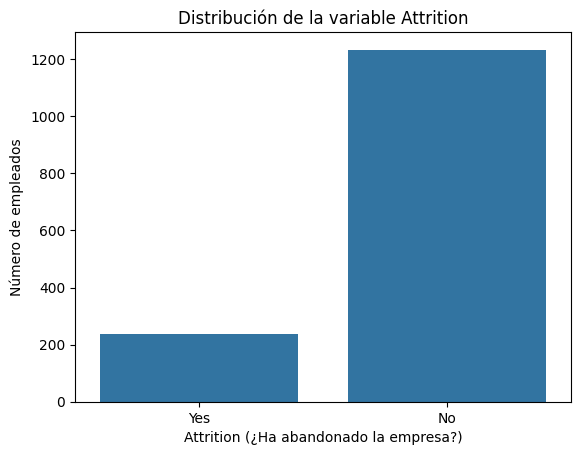

In [4]:
# Visualizamos la variable objetivo
sns.countplot(x='Attrition', data=df)
plt.title('Distribución de la variable Attrition')
plt.xlabel('Attrition (¿Ha abandonado la empresa?)')
plt.ylabel('Número de empleados')
plt.show()

In [5]:
# Conteo de la variable objetivo
print(df['Attrition'].value_counts())

# Porcentaje de cada valor de la variable
print(df['Attrition'].value_counts(normalize=True) * 100)

Attrition
No     1233
Yes     237
Name: count, dtype: int64
Attrition
No     83.877551
Yes    16.122449
Name: proportion, dtype: float64


El dataset está desbalanceado (~16% abandonos), por lo que priorizaremos métricas como recall.

### 📄 Descripción de las variables del dataset

| Columna                     | Descripción                                                                 |
|-----------------------------|-----------------------------------------------------------------------------|
| **Age**                     | Edad del empleado.                                                          |
| **Attrition**               | Si el empleado ha abandonado la empresa (`Yes`) o no (`No`).               |
| **BusinessTravel**          | Frecuencia con la que el empleado viaja por trabajo.                        |
| **Department**              | Departamento en el que trabaja el empleado (Ventas, I+D, RRHH).             |
| **DistanceFromHome**        | Distancia (en millas) desde su casa al trabajo.                             |
| **Education**               | Nivel educativo (1=Menor, 5=Mayor).                                         |
| **EducationField**          | Área de formación (Ciencias, Marketing, Medicina, etc.).                    |
| **EnvironmentSatisfaction** | Grado de satisfacción con el entorno laboral (1 a 4).                      |
| **Gender**                  | Género del empleado.                                                        |
| **JobRole**                 | Cargo o puesto de trabajo específico.                                       |
| **JobSatisfaction**         | Grado de satisfacción con su trabajo (1 a 4).                               |
| **MaritalStatus**           | Estado civil (Soltero, Casado, Divorciado).                                |
| **MonthlyIncome**           | Ingreso mensual.                                                            |
| **NumCompaniesWorked**      | Número de empresas anteriores en las que ha trabajado.                      |
| **OverTime**                | Si realiza horas extra (`Yes` o `No`).                                      |
| **PercentSalaryHike**       | Porcentaje del último aumento salarial.                                    |
| **StockOptionLevel**        | Nivel de participación accionarial.                                        |
| **TotalWorkingYears**       | Años totales de experiencia laboral.                                        |
| **TrainingTimesLastYear**   | Número de formaciones completadas el último año.                           |
| **WorkLifeBalance**         | Equilibrio entre vida personal y trabajo (1=Malo, 4=Excelente).             |
| **YearsAtCompany**          | Años que lleva en la empresa.                                              |
| **YearsInCurrentRole**      | Años en su puesto actual.                                                  |
| **YearsSinceLastPromotion** | Años desde la última promoción.                                            |
| **YearsWithCurrManager**    | Años trabajando con el actual supervisor.                                   |


## **Paso 4: Análisis exploratorio (Mini EDA)**

En este paso exploramos la estructura y características principales del dataset para entender mejor la variable objetivo y las posibles relaciones con otras variables.



In [6]:
# Valores nulos
print(df.isnull().sum().sort_values(ascending=False).head())

Age               0
Attrition         0
BusinessTravel    0
DailyRate         0
Department        0
dtype: int64


In [7]:
# Estadísticas generales
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [8]:
# Correlación con variable objetivo binarizada
df["Attrition_bin"] = df["Attrition"].map({"Yes": 1, "No": 0})
correlaciones = df.corr(numeric_only=True)["Attrition_bin"].sort_values(ascending=False)
print(correlaciones)

Attrition_bin               1.000000
DistanceFromHome            0.077924
NumCompaniesWorked          0.043494
MonthlyRate                 0.015170
PerformanceRating           0.002889
HourlyRate                 -0.006846
EmployeeNumber             -0.010577
PercentSalaryHike          -0.013478
Education                  -0.031373
YearsSinceLastPromotion    -0.033019
RelationshipSatisfaction   -0.045872
DailyRate                  -0.056652
TrainingTimesLastYear      -0.059478
WorkLifeBalance            -0.063939
EnvironmentSatisfaction    -0.103369
JobSatisfaction            -0.103481
JobInvolvement             -0.130016
YearsAtCompany             -0.134392
StockOptionLevel           -0.137145
YearsWithCurrManager       -0.156199
Age                        -0.159205
MonthlyIncome              -0.159840
YearsInCurrentRole         -0.160545
JobLevel                   -0.169105
TotalWorkingYears          -0.171063
EmployeeCount                    NaN
StandardHours                    NaN
N

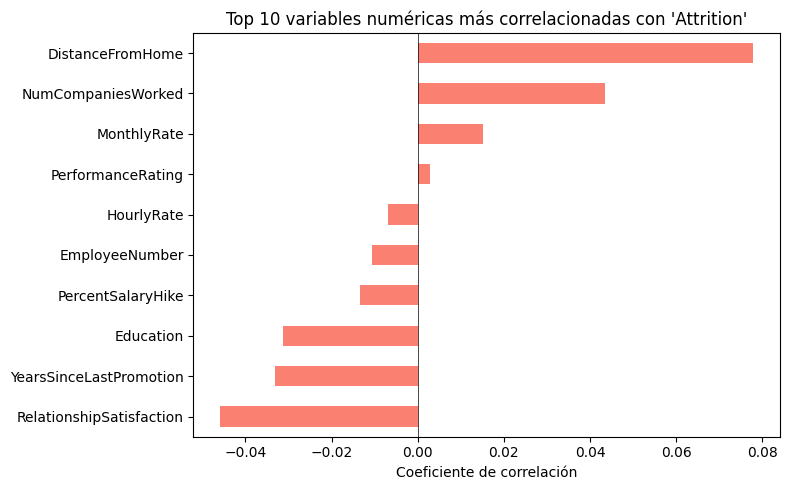

In [9]:
# Visualizamos las 10 variables numéricas más correlacionadas con la rotación
plt.figure(figsize=(8, 5))
correlaciones.drop("Attrition_bin").head(10).plot(kind='barh', color='salmon')
plt.title("Top 10 variables numéricas más correlacionadas con 'Attrition'")
plt.xlabel("Coeficiente de correlación")
plt.axvline(0, color='black', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Tras analizar las correlaciones numéricas con la variable objetivo (`Attrition_bin`), observamos que algunas variables presentan coeficientes muy cercanos a cero, lo que indica que tienen poca o ninguna relación lineal con la rotación de empleados.

Variables como `EmployeeNumber`, `PerformanceRating`, `HourlyRate` o `PercentSalaryHike` muestran una correlación muy baja o negativa con `Attrition_bin`. Por ello, en el siguiente paso procederemos a **descartar estas variables consideradas poco relevantes** para mejorar la eficiencia y la interpretabilidad del modelo.

Esta eliminación se realizará antes del entrenamiento, asegurando que el modelo solo trabaje con variables con potencial predictivo.



In [10]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'Attrition_bin'],
      dtype='object')

In [11]:
# Variables numéricas que eliminaremos por baja correlación o poca variabilidad
cols_a_eliminar = [
    'EmployeeCount',       # constante (1 para todos)
    'StandardHours',       # constante (80 para todos)
    'EmployeeNumber',      # ID único, no aporta info útil
    'Over18'               # si existe, generalmente constante
]

# Algunas variables con correlación casi nula o negativa pueden eliminarse también:
cols_baja_corr = [
    'PerformanceRating', 
    'HourlyRate', 
    'PercentSalaryHike', 
    'MonthlyRate', 
    'DailyRate', 
    'TrainingTimesLastYear'
]

cols_a_eliminar += cols_baja_corr

# Eliminamos esas columnas del dataframe para el análisis/modelado posterior
dfnew = df.drop(columns=cols_a_eliminar)

print(f"Columnas eliminadas: {cols_a_eliminar}")
dfnew.shape

Columnas eliminadas: ['EmployeeCount', 'StandardHours', 'EmployeeNumber', 'Over18', 'PerformanceRating', 'HourlyRate', 'PercentSalaryHike', 'MonthlyRate', 'DailyRate', 'TrainingTimesLastYear']


(1470, 26)

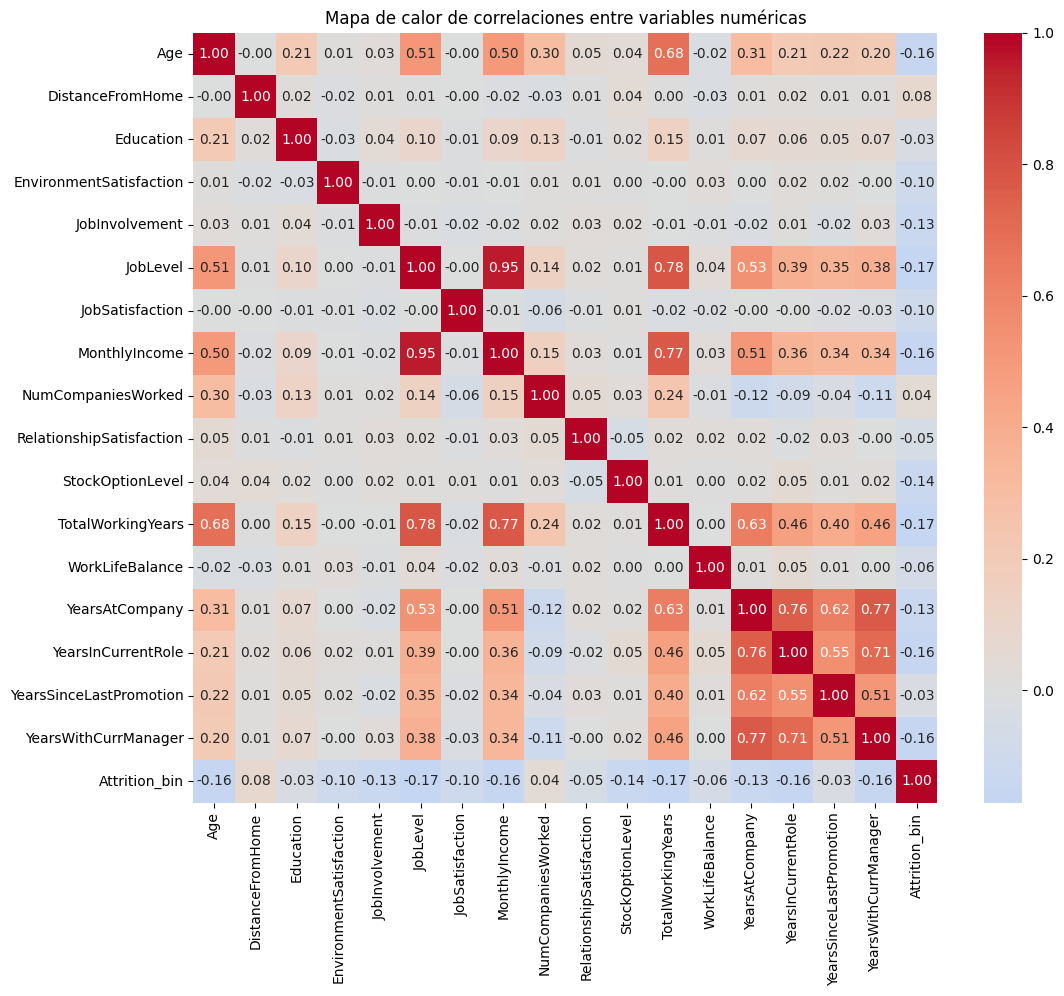

In [12]:
plt.figure(figsize=(12,10))
sns.heatmap(dfnew.select_dtypes(include=['int64', 'float64']).corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Mapa de calor de correlaciones entre variables numéricas")
plt.show()

### Interpretación del mapa de calor

- Las variables más asociadas con la rotación (`Attrition_bin`) son:
  - **JobLevel**, **MonthlyIncome**, **TotalWorkingYears**, **YearsAtCompany**, **JobInvolvement**, todas con coeficientes negativos, lo que indica que a mayor antigüedad, implicación o salario, menor probabilidad de abandono.
  
- Se observa **colinealidad** entre algunas variables:
  - `MonthlyIncome`, `JobLevel` y `TotalWorkingYears` están altamente correlacionadas (coeficientes > 0.75).
  - `YearsWithCurrManager` y `YearsInCurrentRole` también.
  
Estas relaciones deben considerarse al seleccionar variables o aplicar técnicas de reducción de dimensionalidad.


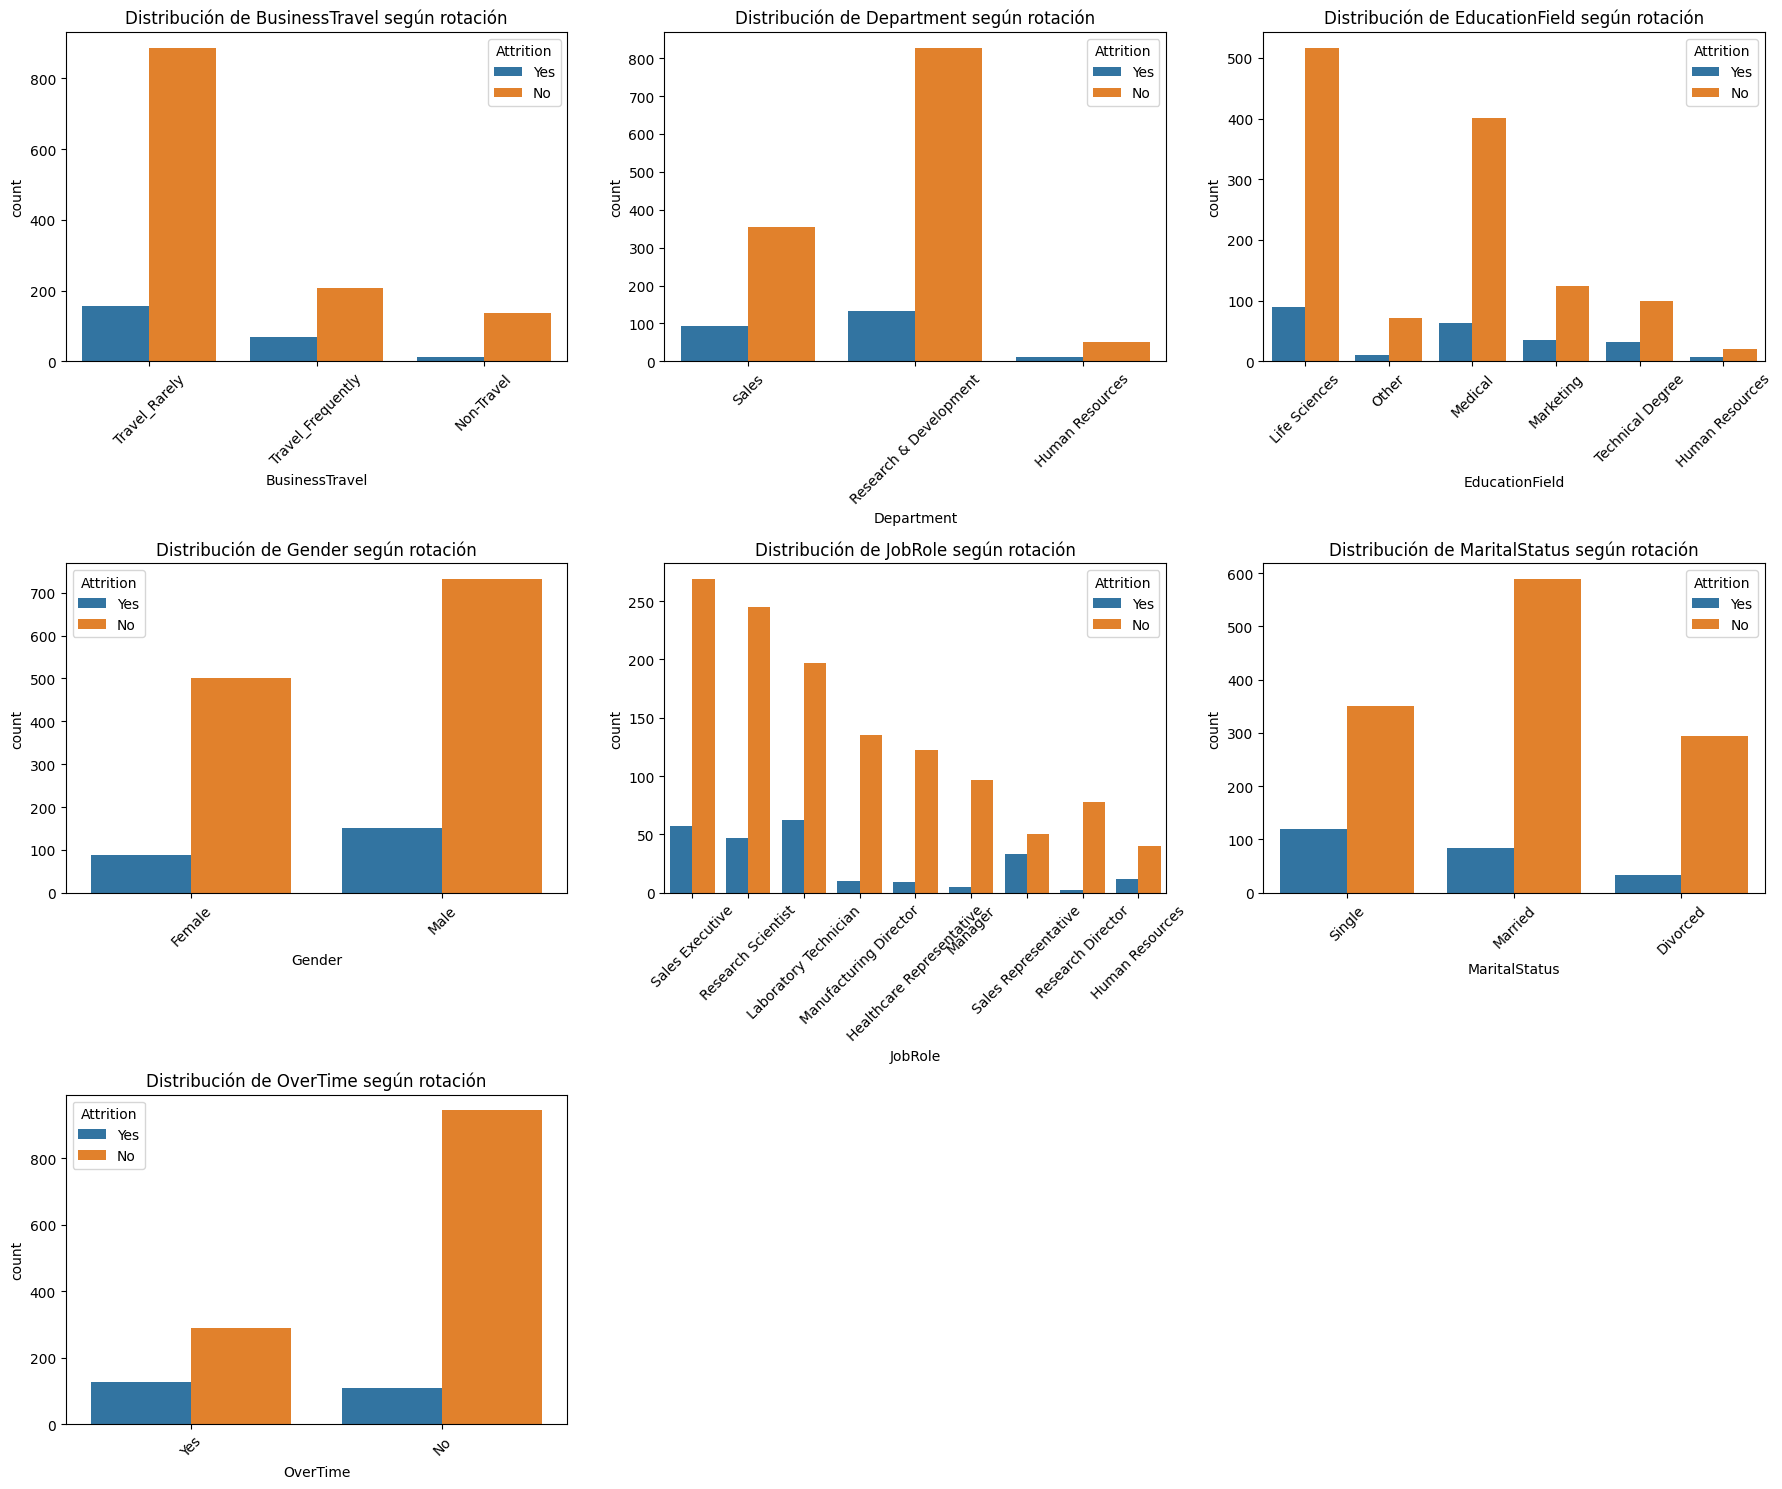

In [13]:
# Columnas categóricas excluyendo la variable objetivo
categorical_cols = dfnew.select_dtypes(include=['object']).columns.drop('Attrition')

# Definir número de columnas (por estética)
n_cols = 3
n_plots = len(categorical_cols)
n_rows = (n_plots + n_cols - 1) // n_cols  # redondeo hacia arriba sin usar math.ceil

# Crear figura
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = axes.flatten()

# Visualizar
for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, hue='Attrition', data=dfnew, ax=axes[i])
    axes[i].set_title(f'Distribución de {col} según rotación')
    axes[i].tick_params(axis='x', rotation=45)

# Eliminar subplots vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


- Se observan diferencias claras en la distribución de la variable `Attrition` según varias variables categóricas.
- Empleados que hacen horas extra (`OverTime = Yes`), que viajan con frecuencia (`BusinessTravel = Travel_Frequently`) o que están solteros (`MaritalStatus = Single`) presentan una mayor proporción de abandono.
- Algunos roles (`JobRole`) y departamentos también muestran tendencias específicas en relación con la rotación.
- Estos patrones visuales sugieren que ciertas categorías están asociadas con un mayor riesgo de abandono, lo que justifica que la incluyamos para el modelado posterior.


In [ ]:
# Test Chi2 para las variables categoricas
for col in categorical_cols:
    tabla = pd.crosstab(dfnew[col], dfnew['Attrition'])
    chi2, p, dof, expected = chi2_contingency(tabla)
    print(f"↪ {col}: p-valor = {p:.4f}")
    if p < 0.05:
        print("   ✔ Asociación estadísticamente significativa con Attrition")
    else:
        print("   ✖ No hay asociación significativa con Attrition")
    print("-" * 60)

↪ BusinessTravel: p-valor = 0.0000
   ✔ Asociación estadísticamente significativa con Attrition
------------------------------------------------------------
↪ Department: p-valor = 0.0045
   ✔ Asociación estadísticamente significativa con Attrition
------------------------------------------------------------
↪ EducationField: p-valor = 0.0068
   ✔ Asociación estadísticamente significativa con Attrition
------------------------------------------------------------
↪ Gender: p-valor = 0.2906
   ✖ No hay asociación significativa con Attrition
------------------------------------------------------------
↪ JobRole: p-valor = 0.0000
   ✔ Asociación estadísticamente significativa con Attrition
------------------------------------------------------------
↪ MaritalStatus: p-valor = 0.0000
   ✔ Asociación estadísticamente significativa con Attrition
------------------------------------------------------------
↪ OverTime: p-valor = 0.0000
   ✔ Asociación estadísticamente significativa con Attritio

In [15]:
# Eliminamos la variable 'Gender' por no aportar información relevante al target
dfnew = dfnew.drop(columns='Gender')

# Confirmamos
print("Gender eliminado. Columnas actuales:")
dfnew.columns.tolist()

Gender eliminado. Columnas actuales:


['Age',
 'Attrition',
 'BusinessTravel',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EnvironmentSatisfaction',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'OverTime',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'Attrition_bin']

### Conclusiones del test Chi-cuadrado

El test Chi-cuadrado confirma que **la mayoría de las variables categóricas analizadas presentan una asociación estadísticamente significativa con la rotación de empleados (`Attrition`)**:

- ✔ `BusinessTravel`, `Department`, `EducationField`, `JobRole`, `MaritalStatus` y `OverTime` tienen un **p-valor < 0.05**, lo que indica que las diferencias observadas en sus categorías respecto a la rotación **no son aleatorias**.
- ✖ La variable `Gender`, sin embargo, **no muestra una asociación significativa**, lo que sugiere que **el género no influye directamente en la decisión de abandonar la empresa** en este dataset.

Estos resultados respaldan la elección de las variables categóricas más relevantes para incluir en el preprocesamiento y posterior modelado.


In [ ]:
#  Definición de columnas categóricas y numéricas

target = 'Attrition'

cat_features = []
num_features = []

for col in dfnew.columns:
    if col == target:
        continue
    if dfnew[col].dtype == 'object' or dfnew[col].dtype.name == 'category':
        cat_features.append(col)
    elif pd.api.types.is_numeric_dtype(dfnew[col]):
        num_features.append(col)

In [ ]:
# Variables numéricas que representan categorías
categorical_numeric = [
    'Education',
    'EnvironmentSatisfaction',
    'JobInvolvement',
    'JobLevel',
    'JobSatisfaction',
    'RelationshipSatisfaction',
    'StockOptionLevel',
    'WorkLifeBalance'
]

# Convertimos esas columnas a tipo 'category'
dfnew[categorical_numeric] = dfnew[categorical_numeric].astype('category')

# Creamos las listas finales de variables
cat_features = dfnew.select_dtypes(include=['object', 'category']).columns.drop(['Attrition'])
num_features = dfnew.select_dtypes(include=['int64', 'float64']).columns.drop(['Attrition_bin'])


✅ Variables categóricas: ['BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'OverTime', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']
✅ Variables numéricas: ['Age', 'DistanceFromHome', 'MonthlyIncome', 'NumCompaniesWorked', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [38]:
# Función para visualizar variables numéricas por clase del target

def plot_numeric_distributions(df, num_features, target, cols=3, kde=True):
    """
    Visualiza las distribuciones de variables numéricas segmentadas por clases del target.
    """
    rows = math.ceil(len(num_features) / cols)
    plt.figure(figsize=(cols * 5, rows * 4))

    for i, col in enumerate(num_features):
        if df[col].nunique() <= 1:
            continue  # Omitir columnas constantes

        plt.subplot(rows, cols, i + 1)
        sns.histplot(
            data=df,
            x=col,
            hue=target,
            kde=kde,
            stat='density',
            common_norm=False,
            palette='Set2',
            alpha=0.6
        )
        plt.title(f'{col} vs {target}')
        plt.xlabel(col)
        plt.ylabel('Densidad')

    plt.tight_layout()
    plt.show()


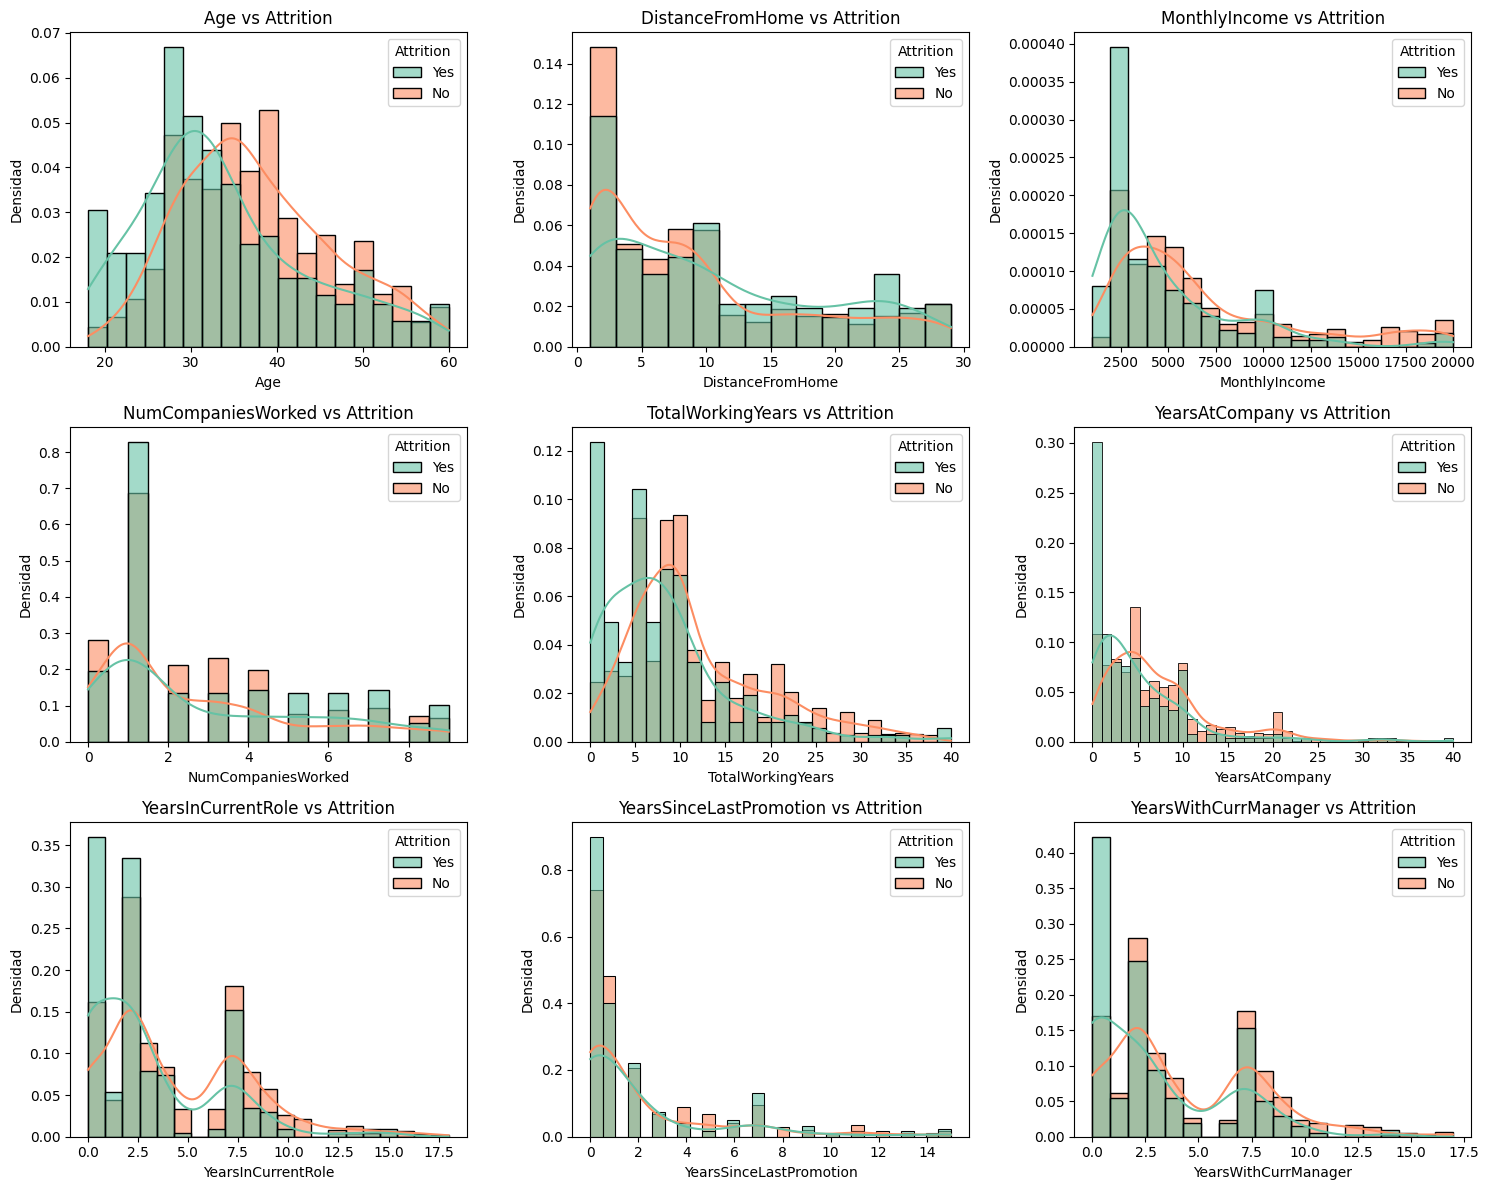

In [39]:
# Visualización final

plot_numeric_distributions(dfnew, num_features=num_features, target=target)

### Conclusión del análisis exploratorio de variables numéricas

A través de las visualizaciones por clase de `Attrition`, se observan ciertos patrones:

- **Edad (Age)**: Los empleados que abandonan tienden a concentrarse en rangos más jóvenes (20-35 años), mientras que los que permanecen están más repartidos.
- **MonthlyIncome** y **TotalWorkingYears** muestran distribuciones a la derecha, con empleados que abandonan más concentrados en los niveles bajos de ingresos y experiencia.
- **YearsAtCompany**, **YearsInCurrentRole**, **YearsSinceLastPromotion** y **YearsWithCurrManager** también reflejan que los empleados con menor antigüedad o sin promociones recientes tienen mayor propensión a rotar.
- **DistanceFromHome** y **NumCompaniesWorked** presentan diferencias leves, pero indican que ciertos extremos podrían relacionarse con la rotación.

Este análisis sugiere que factores como la **edad, experiencia laboral, oportunidades de promoción y estabilidad en la empresa** están asociados con la probabilidad de rotación, lo cual justifica su inclusión en el modelo predictivo.


## **Paso 5: Preprocesamiento de datos y división del conjunto**

En esta etapa realizamos dos tareas clave:

1. **Preprocesamiento**:
   - Escalamos las variables numéricas.
   - Codificamos las variables categóricas usando One-Hot Encoding (eliminando la primera categoría para evitar multicolinealidad).
   - Usamos `ColumnTransformer` para aplicar estas transformaciones de forma conjunta.

2. **División de datos**:
   - Separamos el conjunto de datos en entrenamiento y test (80%-20%) para evaluar el rendimiento del modelo con datos no vistos.


In [47]:
# Variables predictoras y target
X = dfnew.drop(columns=['Attrition', 'Attrition_bin'])
y = dfnew['Attrition']

# División en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Preprocesador: escalado de numéricas + one-hot de categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_features)])

# Confirmación de las columnas seleccionadas
print("Variables numéricas que se escalarán:",num_features )

print("Variables categóricas que se codificarán:", cat_features)

print("Tamaño conjunto entrenamiento:", X_train.shape)
print("Tamaño conjunto test:", X_test.shape)


Variables numéricas que se escalarán: Index(['Age', 'DistanceFromHome', 'MonthlyIncome', 'NumCompaniesWorked',
       'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')
Variables categóricas que se codificarán: Index(['BusinessTravel', 'Department', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'OverTime',
       'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance'],
      dtype='object')
Tamaño conjunto entrenamiento: (1176, 23)
Tamaño conjunto test: (294, 23)


En este paso hemos dejado preparados los datos para el modelado:

- Se ha dividido el conjunto en entrenamiento y test manteniendo la proporción.
- Se ha definido un `ColumnTransformer` que escala las variables numéricas y aplica codificación One-Hot a las categóricas.


## **Paso 6: Entrenamiento y comparación de modelos base**

El objetivo de este paso es entrenar y comparar varios modelos de clasificación utilizando sus **hiperparámetros por defecto**, para seleccionar como baseline aquel que muestre mejor rendimiento en la detección de empleados que abandonan la empresa (`Attrition = Yes`).

Nos centraremos especialmente en la **métrica de `recall`**, ya que nuestro objetivo principal es **detectar con la mayor precisión posible los casos positivosde los empleados que se van**.



In [54]:
# Scorer personalizado para la clase 'Yes'
recall_yes = make_scorer(recall_score, pos_label='Yes')

# Modelos
modelos = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    }

# Comparación
resultados = {}

for nombre, modelo in modelos.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', modelo)
    ])
    
    # Para XGBoost usamos la variable binaria
    if nombre == 'XGBoost':
        y_train_temp = y_train.map({'No': 0, 'Yes': 1})
        recall_binario = make_scorer(recall_score, pos_label=1)
        scores = cross_val_score(pipe, X_train, y_train_temp, cv=5, scoring=recall_binario)
    else:
        scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring=recall_yes)

    resultados[nombre] = {
        'Recall (YES) medio': np.mean(scores),
        'Recall (YES) std': np.std(scores)
    }

# Mostrar resultados
df_resultados = pd.DataFrame(resultados).T.sort_values(by='Recall (YES) medio', ascending=False)
display(df_resultados)

,Recall (YES) medio,Recall (YES) std
Logistic Regression,0.447368,0.086483
XGBoost,0.378947,0.039386
Decision Tree,0.352632,0.045883
Gradient Boosting,0.352632,0.080854
Random Forest,0.184211,0.037216
KNN,0.178947,0.065314


Tras evaluar varios modelos de clasificación mediante validación cruzada y utilizando el recall sobre la clase "Yes" como métrica principal, observamos que **Logistic Regression** se posiciona como el modelo más fiable para detectar empleados que abandonan la empresa.

Con un recall medio de **0.447**, este modelo logra detectar aproximadamente un **45% de los casos reales de abandono**, lo que lo convierte en una opción sólida como **modelo baseline**. Además, presenta una desviación estándar relativamente baja, lo que indica estabilidad en las distintas particiones del conjunto de entrenamiento.

A partir de este punto, evaluaremos su rendimiento en el conjunto de test y lo consideraremos para una futura optimización.


## Paso 7: Entrenamiento y Evaluación del Modelo Baseline

En este paso entrenamos nuestro modelo baseline, seleccionado previamente tras comparar varios algoritmos.  
El modelo elegido es **Logistic Regression**, ya que obtuvo el mejor recall medio sobre la clase `"Yes"` (rotación laboral) en validación cruzada.  
Nuestro objetivo es evaluar su rendimiento inicial sobre el conjunto de test y establecer una referencia clara para futuras mejoras.

A continuación, entrenamos el modelo, realizamos las predicciones y analizamos las métricas de evaluación, incluyendo la matriz de confusión.


 Classification Report - Baseline (Logistic Regression):

              precision    recall  f1-score   support

          No       0.94      0.78      0.85       247
         Yes       0.39      0.72      0.50        47

    accuracy                           0.77       294
   macro avg       0.66      0.75      0.68       294
weighted avg       0.85      0.77      0.80       294



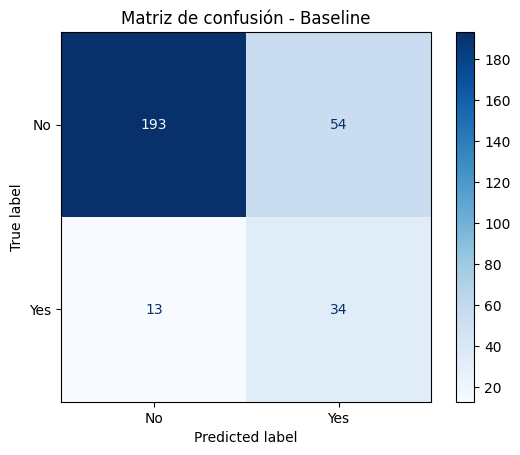

In [58]:
# Creamos un pipeline con el preprocesador y el modelo baseline
baseline_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# Entrenamiento del modelo baseline
baseline_model.fit(X_train, y_train)

# Predicciones sobre el conjunto de test
y_pred = baseline_model.predict(X_test)

# Reporte de clasificación
print(" Classification Report - Baseline (Logistic Regression):\n")
print(classification_report(y_test, y_pred))

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Matriz de confusión - Baseline")
plt.show()

He utilizado `Logistic Regression` con `class_weight='balanced'` como modelo baseline, ya que ofrece un buen equilibrio entre simplicidad, interpretabilidad y rendimiento inicial.

En el conjunto de test, el modelo ha alcanzado los siguientes resultados:

- **Recall para la clase *Yes* (rotación): 0.72**, lo que indica que detecta correctamente al 72% de los empleados que efectivamente abandonan la empresa.
- **Precision para la clase *Yes*: 0.39**, lo que implica que también comete falsos positivos. Sin embargo, considero este margen asumible si el objetivo es minimizar la fuga real de trabajadores.
- **Recall macro promedio: 0.75**, lo que sugiere un buen equilibrio entre ambas clases.

Dado que el objetivo principal del proyecto es **priorizar la detección fiable de los empleados que podrían marcharse**, este baseline ya representa una base sólida para aplicar posteriormente técnicas de optimización y mejorar su rendimiento.

## Paso 8: Optimización del Modelo

El objetivo de este paso es **mejorar el rendimiento del modelo baseline** aplicando una búsqueda de los mejores hiperparámetros mediante **validación cruzada con `GridSearchCV`**.

Dado que el modelo baseline ya ofrece un rendimiento aceptable, especialmente en el recall de la clase *Yes*, se pretende **afinar el comportamiento del modelo para aumentar su capacidad predictiva sin perder interpretabilidad**.

### Vamos a ...

- Utilizar el algoritmo `LogisticRegression` como base.
- Aplicar validación cruzada con `GridSearchCV` para explorar distintas combinaciones de hiperparámetros.
- Establecer como **métrica de evaluación el `recall`**, ya que queremos **detectar la mayor proporción posible de empleados que podrían abandonar la empresa**.
- Evaluar si el modelo optimizado mejora significativamente respecto al baseline.


Fitting 5 folds for each of 16 candidates, totalling 80 fits
 Mejores hiperparámetros encontrados:
{'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}

 Classification Report - Modelo Optimizado (Logistic Regression):

              precision    recall  f1-score   support

          No       0.89      0.43      0.58       247
         Yes       0.20      0.72      0.31        47

    accuracy                           0.48       294
   macro avg       0.54      0.58      0.45       294
weighted avg       0.78      0.48      0.54       294



c:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


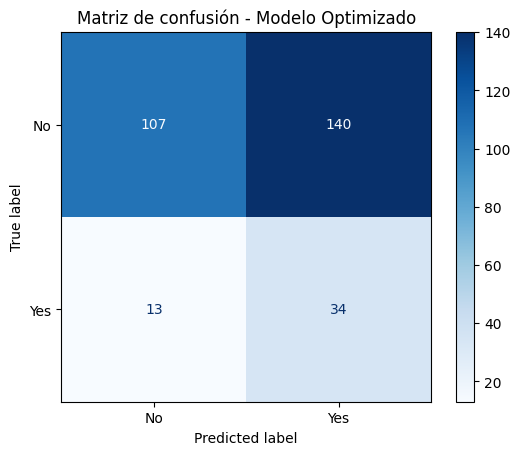

In [65]:
# Definimos el grid de hiperparámetros
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__class_weight': ['balanced']
}

# Configuramos el GridSearch con validación cruzada y optimización de recall
grid_search = GridSearchCV(
    estimator=baseline_model,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Entrenamiento del GridSearch
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print(" Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Evaluación del mejor modelo en el conjunto de test
y_pred_opt = grid_search.predict(X_test)

# Reporte de clasificación del modelo optimizado
print("\n Classification Report - Modelo Optimizado (Logistic Regression):\n")
print(classification_report(y_test, y_pred_opt))

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_opt, cmap='Blues')
plt.title("Matriz de confusión - Modelo Optimizado")
plt.show()

Aunque el *recall* se mantuvo alto, la precisión cayó drásticamente, lo que significa que el modelo cometía muchos falsos positivos. Además, el rendimiento general del modelo (accuracy y macro average) también empeoró considerablemente en comparación con el modelo base.

Este resultado me llevó a sospechar que el espacio de búsqueda de hiperparámetros era demasiado limitado o mal definido, y que probablemente algunas combinaciones estaban generando errores.

Por este motivo, opté por usar **`RandomizedSearchCV`**, que permite una búsqueda más amplia y flexible dentro de un espacio continuo de parámetros. Esta técnica puede encontrar configuraciones óptimas de forma más eficiente y con menor riesgo de overfitting en comparación con un grid cerrado y pequeño.


In [71]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_dist = {
    'classifier__C': uniform(0.001, 10),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__class_weight': ['balanced']
}

random_search = RandomizedSearchCV(
    estimator=baseline_model,
    param_distributions=param_dist,
    n_iter=30,  # Número de combinaciones aleatorias a probar
    scoring='recall',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)
# Mostrar los mejores parámetros encontrados en formato param_grid
best_params = random_search.best_params_
print("Mejores hiperparámetros encontrados:\n")
print(f"param_grid = {{\n" +
      "\n".join([f"    '{k}': [{repr(v)}]," for k, v in best_params.items()]) +
      "\n}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Mejores hiperparámetros encontrados:

param_grid = {
    'classifier__C': [np.float64(3.746401188473625)],
    'classifier__class_weight': ['balanced'],
    'classifier__penalty': ['l1'],
    'classifier__solver': ['liblinear'],
}


c:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
 Mejores hiperparámetros encontrados:
{'classifier__C': 3.75, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}

 Classification Report - Modelo Optimizado (Logistic Regression):

              precision    recall  f1-score   support

          No       0.94      0.79      0.86       247
         Yes       0.40      0.72      0.51        47

    accuracy                           0.78       294
   macro avg       0.67      0.76      0.68       294
weighted avg       0.85      0.78      0.80       294



c:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


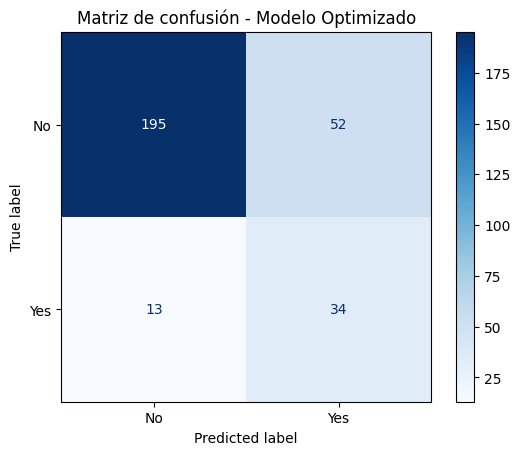

In [81]:
# Definimos el grid de hiperparámetros
param_grid = {
  'classifier__C': [3.75],
  'classifier__class_weight': ['balanced'],
  'classifier__penalty': ['l1'],
  'classifier__solver': ['liblinear']
}

# Configuramos el GridSearch con validación cruzada y optimización de recall
grid_search = GridSearchCV(
    estimator=baseline_model,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Entrenamiento del GridSearch
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print(" Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Evaluación del mejor modelo en el conjunto de test
y_pred_opt = grid_search.predict(X_test)

# Reporte de clasificación del modelo optimizado
print("\n Classification Report - Modelo Optimizado (Logistic Regression):\n")
print(classification_report(y_test, y_pred_opt))

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_opt, cmap='Blues')
plt.title("Matriz de confusión - Modelo Optimizado")
plt.show()
# Guardar imagen
plt.savefig('src/img/matriz_confusion_logreg.png', dpi=300, bbox_inches='tight')
plt.close()

### Evaluación final del modelo optimizado (Logistic Regression)

Tras ajustar el modelo con los mejores hiperparámetros, el rendimiento final sobre el conjunto de test ha sido el siguiente:

- **Recall para la clase Yes (rotación)**: 0.72 → El modelo es capaz de detectar correctamente al 72% de los empleados que realmente se van, cumpliendo con el objetivo principal del proyecto.
- **Precision para la clase Yes**: 0.40 → Aunque existen falsos positivos, es un valor asumible si lo que se prioriza es minimizar la fuga real de talento.
- **F1-score para la clase Yes**: 0.51 → Esta métrica armoniza precision y recall, y mejora significativamente respecto al modelo baseline.
- **Accuracy global**: 0.78 → Buena tasa de aciertos generales, aunque recordemos que no es la métrica más adecuada en casos con clases desbalanceadas.
- **Macro avg (recall)**: 0.76 → Indica un equilibrio bastante correcto entre ambas clases.

En conjunto, estos resultados confirman que el modelo optimizado ha superado al baseline, sobre todo en el objetivo principal: detectar empleados con alta probabilidad de abandonar la empresa.


### Paso 9: Interpretabilidad del Modelo mediante Coeficientes

Vamos a entender cómo cada variable influye en la predicción de la rotación laboral. Para ello, vamos a analizar los **coeficientes del modelo**.

En este bloque de código:

- Extraigo el modelo final entrenado desde el pipeline (`best_estimator_`).
- Accedo directamente al estimador de regresión logística (`classifier`) y al codificador de variables categóricas (`OneHotEncoder`) aplicado durante el preprocesamiento.
- Reconstruyo la lista completa de variables utilizadas, uniendo:
  - Las variables numéricas originales.
  - Las variables categóricas transformadas tras el OneHotEncoding.
- Creo un DataFrame con los nombres de las variables y sus coeficientes estimados por el modelo.
- Añado una columna que indica si cada variable **↑ aumenta** o **↓ disminuye** la probabilidad de que un empleado abandone la empresa.
- Finalmente, visualizo los coeficientes mediante un gráfico de barras horizontales.

Este paso es clave para convertir el modelo en una **herramienta explicativa y accionable** para el departamento de Recursos Humanos, ya que permite identificar qué factores están más asociados con el riesgo de abandono laboral.


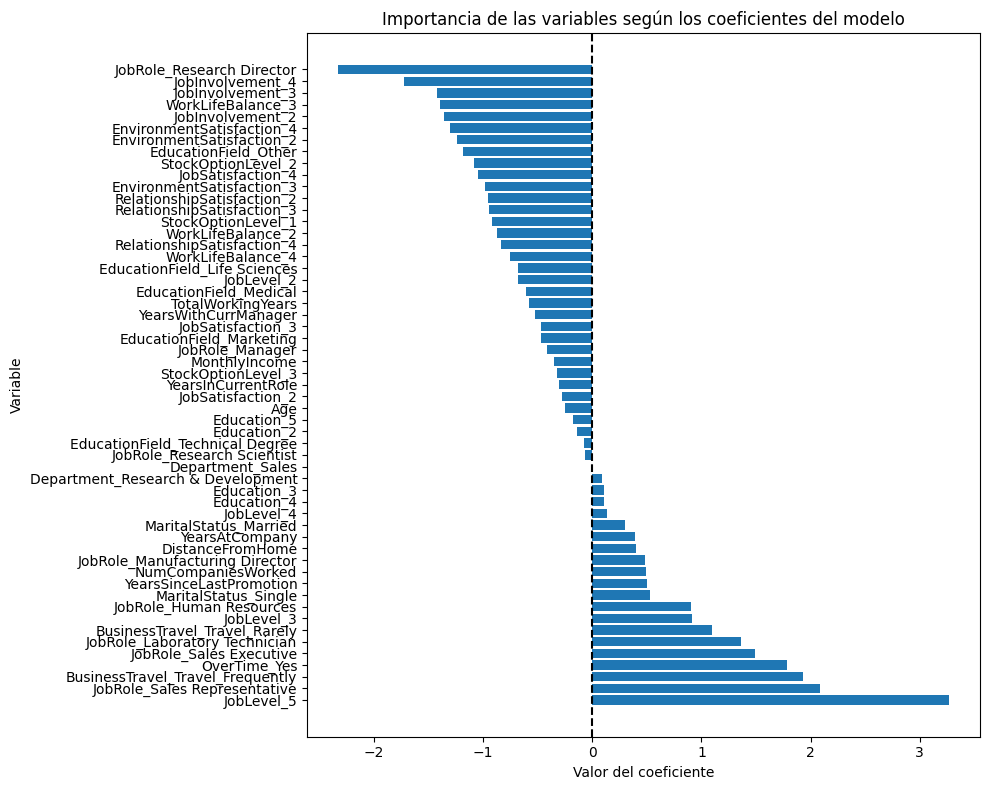

In [77]:
# Extraer el modelo entrenado del pipeline
best_model = grid_search.best_estimator_
log_reg = best_model.named_steps['classifier']
encoder = best_model.named_steps['preprocessor'].named_transformers_['cat']
encoded_features = encoder.get_feature_names_out(cat_features)

# Obtener nombres de todas las variables tras preprocesamiento
all_features = np.concatenate([num_features, encoded_features])

# Coeficientes y su impacto
coef = log_reg.coef_[0]
coef_df = pd.DataFrame({
    'Feature': all_features,
    'Coeficiente': coef
})
coef_df['Impacto'] = coef_df['Coeficiente'].apply(lambda x: '↑ aumenta la probabilidad' if x > 0 else '↓ disminuye la probabilidad')
coef_df = coef_df.sort_values(by='Coeficiente', ascending=False)

# Visualización
plt.figure(figsize=(10, 8))
plt.barh(coef_df['Feature'], coef_df['Coeficiente'])
plt.axvline(0, color='black', linestyle='--')
plt.title('Importancia de las variables según los coeficientes del modelo')
plt.xlabel('Valor del coeficiente')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()
# Guardar imagen
plt.savefig('./src/img/coeficientes_logreg.png', dpi=300, bbox_inches='tight')
plt.close()


In [74]:
coef_df

,Variable,Coeficiente,Signo
36,cat__JobRole_Research Director,-2.332531,Negativo
27,cat__JobInvolvement_4,-1.726625,Negativo
26,cat__JobInvolvement_3,-1.423919,Negativo
53,cat__WorkLifeBalance_3,-1.393046,Negativo
25,cat__JobInvolvement_2,-1.361856,Negativo
24,cat__EnvironmentSatisfaction_4,-1.306571,Negativo
22,cat__EnvironmentSatisfaction_2,-1.237326,Negativo
20,cat__EducationField_Other,-1.182434,Negativo
50,cat__StockOptionLevel_2,-1.080109,Negativo
42,cat__JobSatisfaction_4,-1.047307,Negativo
